In [16]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
import wandb

import torch
from torch import nn
from torchvision import models
import torch.optim as optim

from dataset import get_dataloaders, get_datasets
from utils import seed_everything
from trainer import Trainer

# Params
Image.MAX_IMAGE_PIXELS = 1e11
CFG = {
    'seed': 42,
    'cv_fold': 5,
    'base_model': 'efficientnet_b1',   # resnet18/34/50, efficientnet_b0/b1/b2/b3/b4
    'img_size': 1024,
    'batch_size': 16,
    'freeze_epochs': 1,
    'epochs': 5,
    'base_lr': 1e-3,
    'affine_degrees': 10,
    'affine_translate': (0.1, 0.1),
    'affine_scale': (0.8, 1.2),
    'dataloader_num_workers': 8,
    'scheduler_step_size': 2,
    'img_color_mean': [0.8708488980328596, 0.75677901508938, 0.8545134911215124],
    'img_color_std': [0.08086288591996027, 0.11553960008706814, 0.06914169213328555],
    'optimizer': 'AdamW',
    'scheduler': 'CosineAnnealingLR',
    'lr_gamma': 0.1,
    'lr_cycl_step_size': 3,
    'sgd_momentum': 0.9,
    'tma_multiplier': 8,
    # 'hed_theta': 0.01,
    # 'color_jitter': {'brightness': 0.2, 'saturation': 0.2, 'hue': 0.1}
}
tags=['torch', 'thumbnails', 'cv']
notes = ''
plot_samples = False

# Wandb
wandb.login(key='1b0401db7513303bdea77fb070097f9d2850cf3b')
run = wandb.init(project='kaggle-ubc-ocean', config=CFG, tags=tags)

# Label encoder/decoder
encode = {'HGSC': 0, 'LGSC': 1, 'EC': 2, 'CC': 3, 'MC': 4}
decode = {v: k for k, v in encode.items()}

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Paths
root = '/media/latlab/MR/projects/kaggle-ubc-ocean'
data_dir = os.path.join(root, 'data')
results_dir = os.path.join(root, 'results')
train_csv = 'train.csv'
train_image_dir = os.path.join(data_dir, 'train_images')
train_thumbnail_dir = os.path.join(data_dir, 'train_thumbnails')

# Seed
seed_everything(CFG['seed'])

# Load data
df = pd.read_csv(os.path.join(data_dir, train_csv))
df['label'] = df.loc[:,'label'].map(encode)

if 'tma_multiplier' in CFG and CFG['tma_multiplier'] > 1:
    df = pd.concat([df] + [df[df['is_tma'] == True]]*CFG['tma_multiplier'], ignore_index=True)

# Functions
def train_model(CFG, train_image_dir, train_thumbnail_dir, df_train, df_validation, encode, wandb_log=False):
    # Data loaders
    datasets = get_datasets(CFG, train_image_dir, train_thumbnail_dir, df_train, df_validation)
    dataloaders = get_dataloaders(CFG, datasets)

    # Model definition
    model = models.get_model(CFG['base_model'], weights='DEFAULT').to(device)

    # Freeze all parameters
    for param in model.parameters():
        param.requires_grad = False
    
    # Replace the last fully-connected layer
    if CFG['base_model'].startswith('resnet'):
        model.fc = nn.Linear(in_features=model.fc.in_features, out_features=len(encode)).to(device)
    elif CFG['base_model'].startswith('efficientnet'):
        model.classifier = nn.Linear(in_features=model.classifier[1].in_features, out_features=len(encode)).to(device)
    
    # Loss function
    loss_fn = nn.CrossEntropyLoss()

    # Optimizer
    if CFG['optimizer'] == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=CFG['base_lr'], momentum=CFG['sgd_momentum'])
    elif CFG['optimizer'] == 'AdamW':
        optimizer = optim.AdamW(model.parameters(), lr=CFG['base_lr'])
    elif CFG['optimizer'] == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=CFG['base_lr'])
    
    # Scheduler
    if CFG['scheduler'] == 'StepLR':
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=CFG['scheduler_step_size'], gamma=CFG['lr_gamma'], verbose=True)
    elif CFG['scheduler'] == 'CyclicLR':
        scheduler = optim.lr_scheduler.CyclicLR(optimizer, base_lr=CFG['base_lr'], max_lr=CFG['base_lr']*10,
                                                step_size_up=3, cycle_momentum=False, mode='triangular2', verbose=True)
    elif CFG['scheduler'] == 'CosineAnnealingLR':
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=CFG['epochs']+CFG['freeze_epochs'], verbose=True)
    elif CFG['scheduler'] == 'OneCycleLR':
        scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=CFG['base_lr'], total_steps=CFG['epochs']+CFG['freeze_epochs'], verbose=True)

    # Training
    trainer = Trainer(model, dataloaders, loss_fn, optimizer, scheduler, device, metric='balanced_accuracy', wandb_log=wandb_log)
    model, _ = trainer.train_epochs(num_epochs=CFG['freeze_epochs'])
    trainer.unfreeze()
    model, balanced_acc = trainer.train_epochs(num_epochs=CFG['epochs'])
    return model, balanced_acc

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

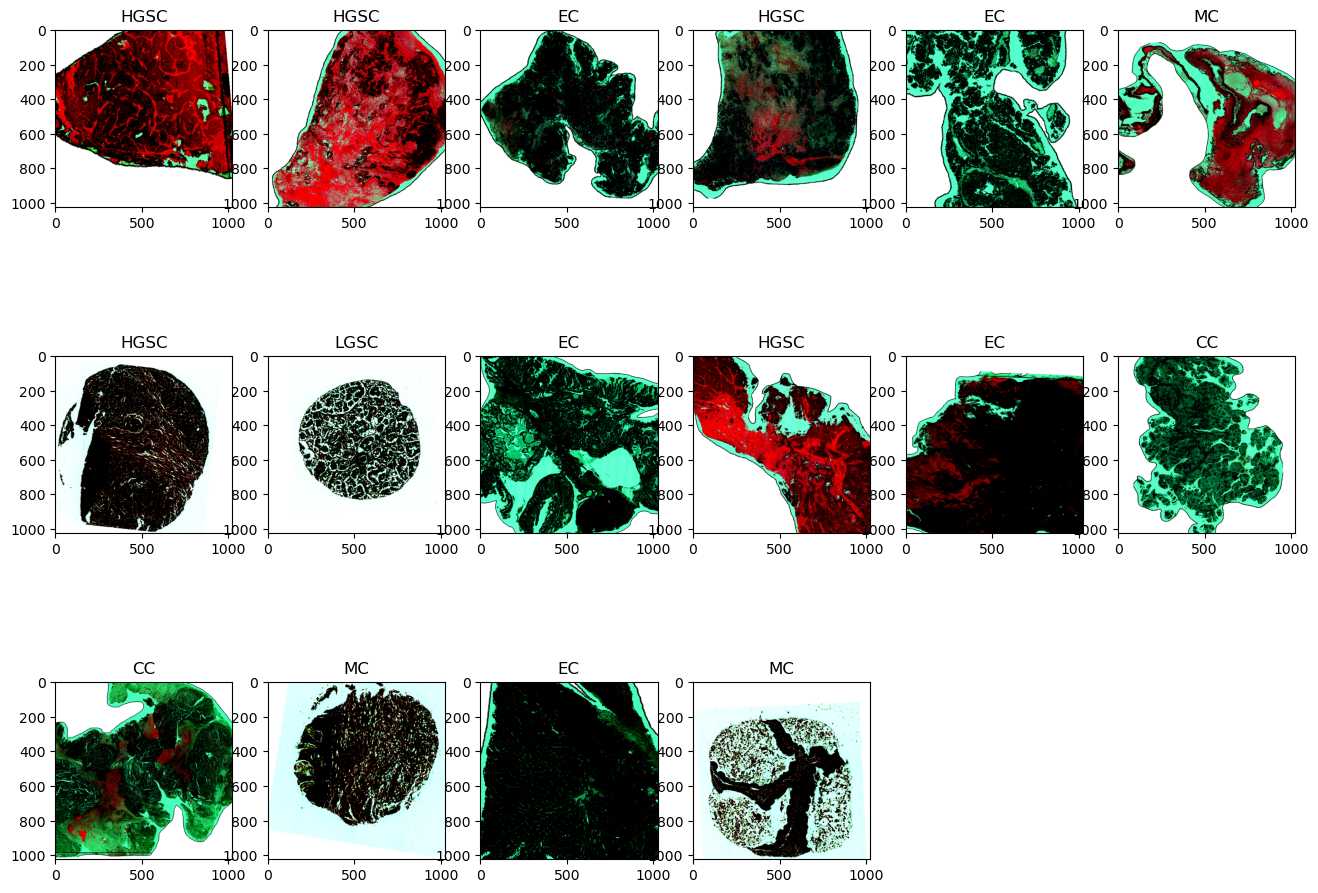

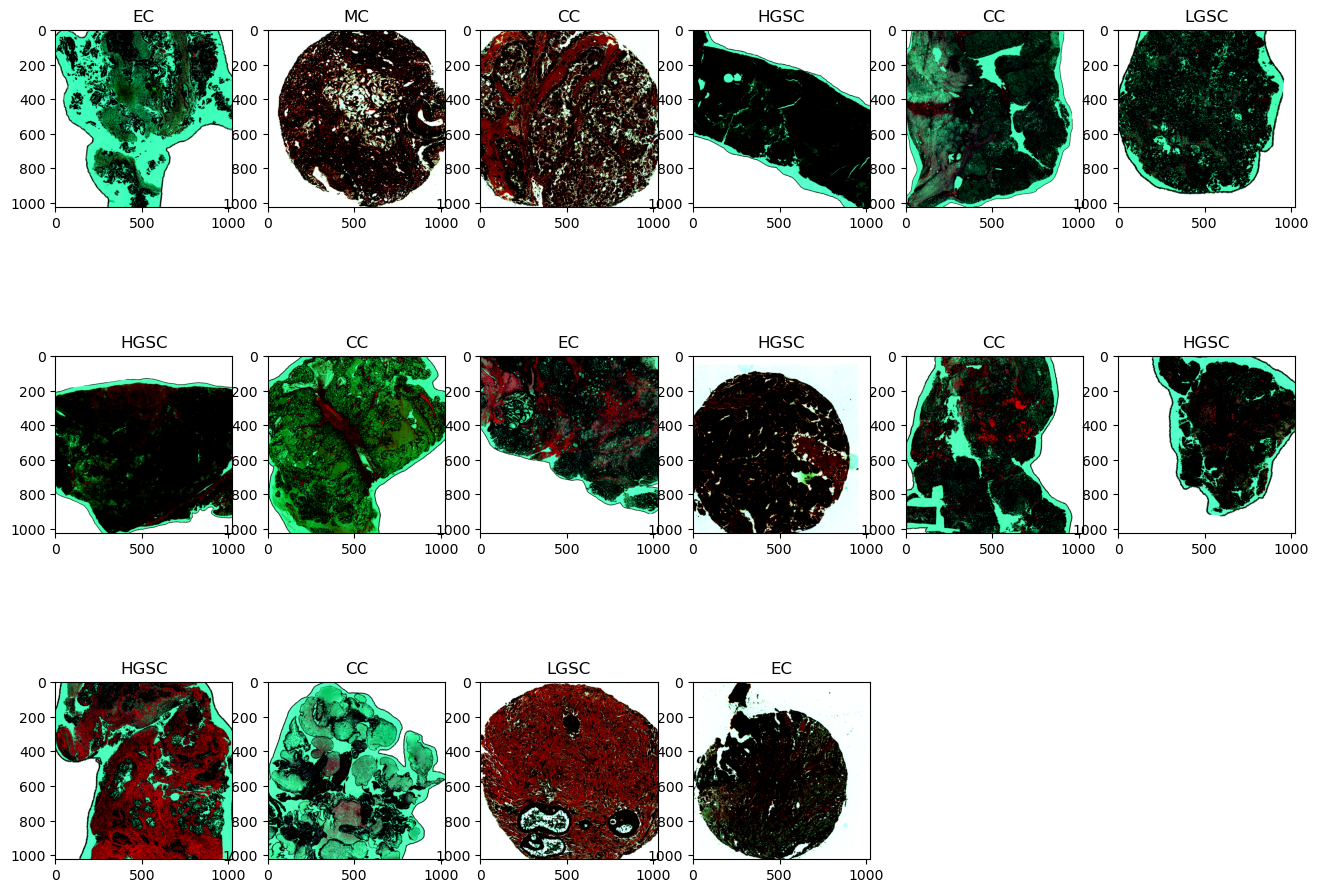

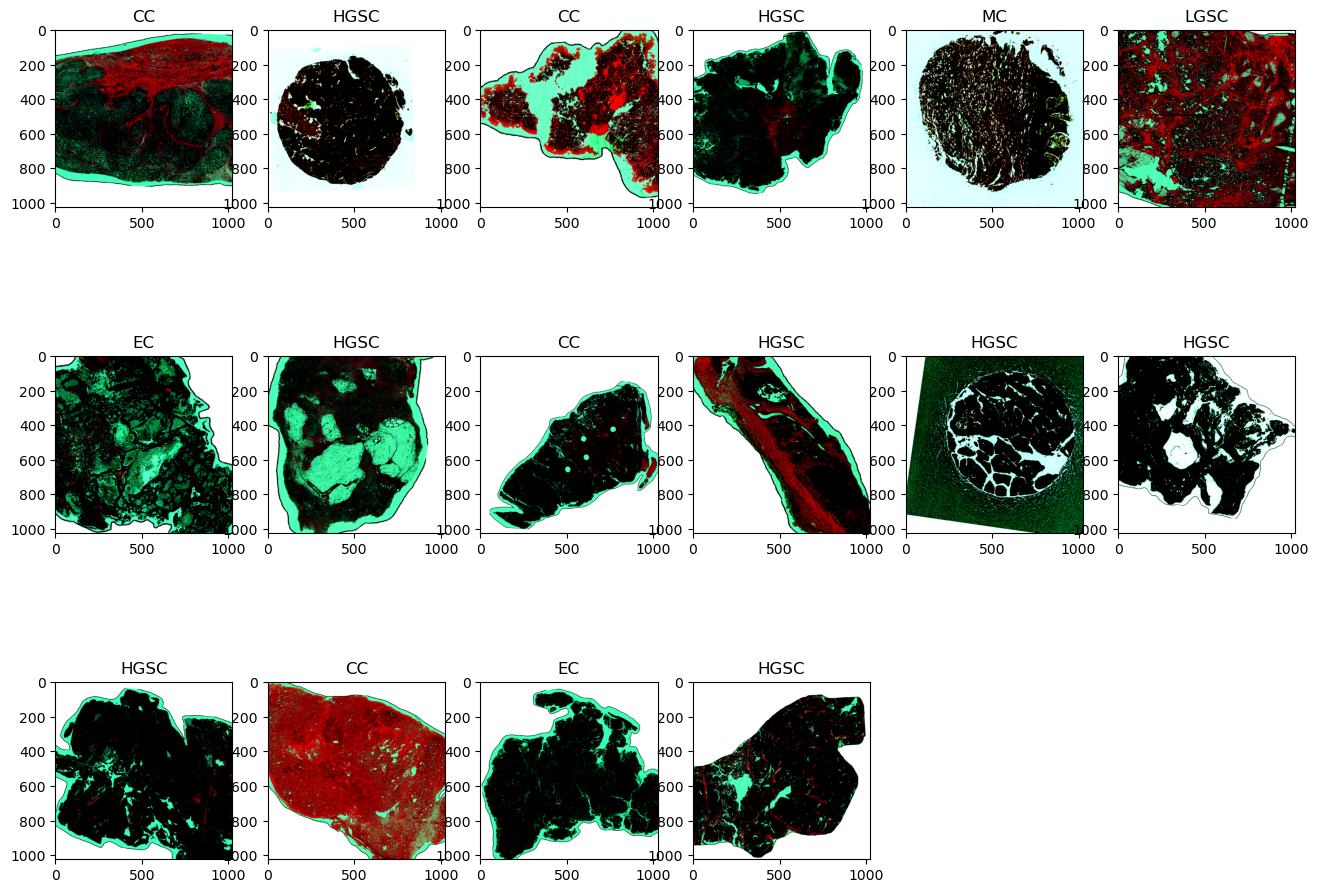

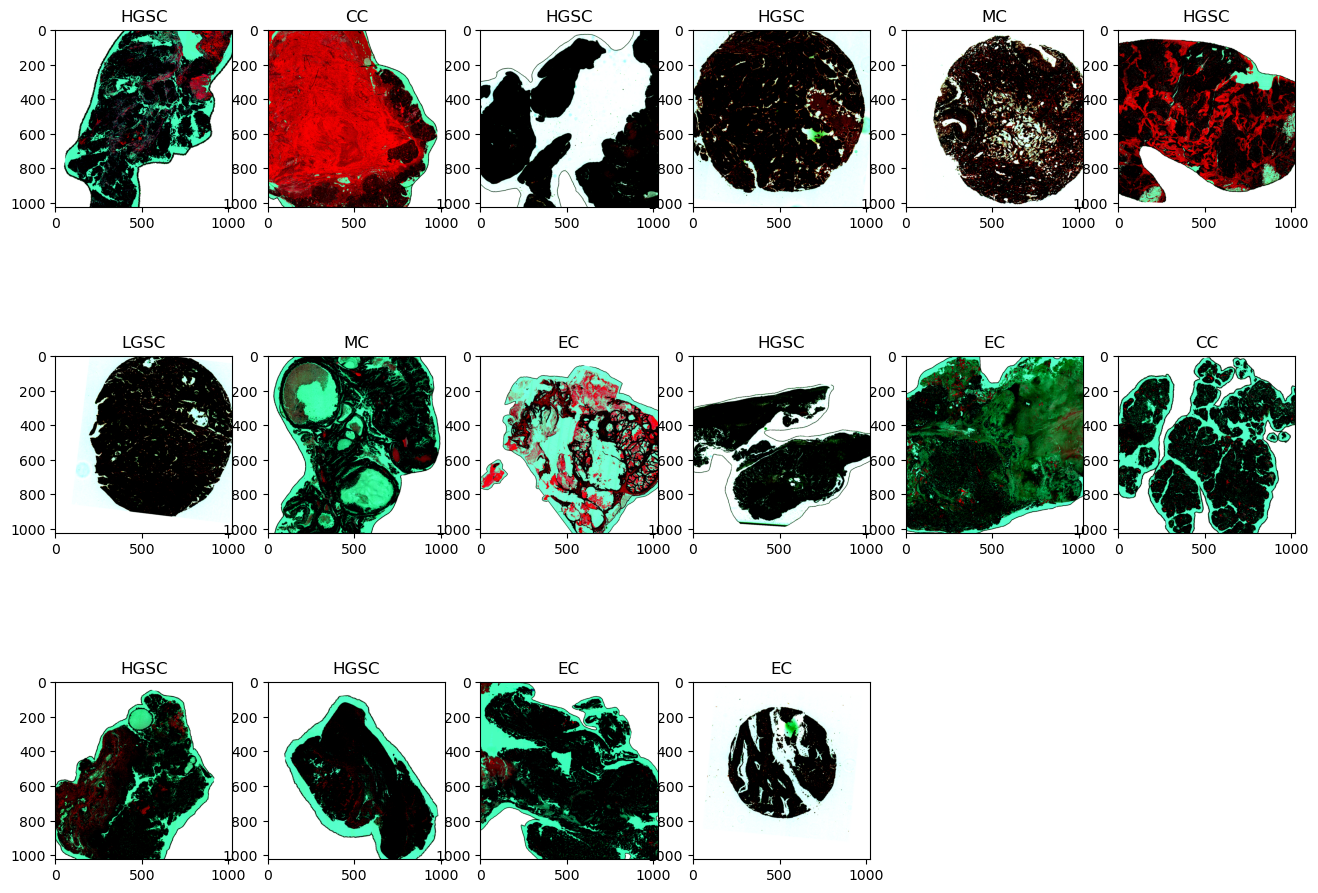

In [17]:
# Show training data
if plot_samples:
    dataloaders = get_dataloaders(CFG, get_datasets(CFG, train_image_dir, train_thumbnail_dir, df, df))
    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloaders['train']):
            plt.figure(figsize=(16, 12))
            for i in range(len(X)):
                plt.subplot(int(np.ceil(len(X)/6)), 6, i+1)
                img_data = X[i].permute(1, 2, 0).cpu().numpy()
                plt.imshow(img_data)
                plt.title(f'{decode[y[i].item()]}')
            if batch >= 3:
                break

In [ ]:
skf = StratifiedKFold(n_splits=CFG['cv_fold'], random_state=CFG['seed'], shuffle=True)
balanced_acc_list = []
for cv, (train_index, valid_index) in enumerate(skf.split(np.zeros(len(df['label'])), df['label'])):
    print(f"Cross-validation fold {cv+1}/{CFG['cv_fold']}")
    df_train = df.iloc[train_index]
    df_validation = df.iloc[valid_index]
    run_name = f'{run.name}-cv{cv+1}'
    model, balanced_acc = train_model(CFG, train_image_dir, train_thumbnail_dir, df_train, df_validation, encode)
    balanced_acc_list.append(balanced_acc)
    torch.save(model.state_dict(), os.path.join(results_dir, 'models', f'ubc-ocean-{run_name}.pt'))
    wandb.log({f'balanced_acc_cv{cv+1}': balanced_acc})
wandb.log({f'mean_balanced_acc': np.mean(balanced_acc_list)})
wandb.finish()

In [ ]:
# Final training on all data
model, _ = train_model(CFG, train_image_dir, train_thumbnail_dir, df, df, encode, wandb_log=False)
torch.save(model.state_dict(), os.path.join(results_dir, 'models', f'ubc-ocean-{run.name}.pt'))